In [1]:
import pandas as pd
from xeofs.models import EOF
import numpy as np
from pacmap import PaCMAP 
import matplotlib.pyplot as plt
from aicsshparam import shtools, shparam
import pyvista as pv

def get_mesh_from_series(coeff_dict, lmax):
    row = pd.Series(coeff_dict)
    coeffs = np.zeros((2, lmax, lmax), dtype=np.float32)
    for l in range(lmax):
        for m in range(l + 1):
            try:
                # Cosine SHE coefficients
                coeffs[0, l, m] = row[
                    [f for f in row.keys() if f"shcoeffs_L{l}M{m}C" in f]
                ]
                # Sine SHE coefficients
                coeffs[1, l, m] = row[
                    [f for f in row.keys() if f"shcoeffs_L{l}M{m}S" in f]
                ]
            # If a given (l,m) pair is not found, it is assumed to be zero
            except: pass
    mesh, _ = shtools.get_reconstruction_from_coeffs(coeffs)
    return mesh

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [22]:
def write_pyvista_track_gif(meshes, out_file, view=None):
    # pv.start_xvfb()
    def dummy_callback(arg):
        return 
    n_time_pts = len(meshes)
    mesh = pv.wrap(meshes[0])
    mesh.clear_data()
    plotter = pv.Plotter(window_size=[800,650])
    plotter.add_mesh(mesh)
    plotter.set_background('white')
    plotter.camera.zoom = 0.6
    if view is not None:
        plotter.camera_position = view
    plotter.open_gif(out_file)
    slider = plotter.add_slider_widget(
        dummy_callback,
        [1, n_time_pts],
        1,
        color="black",
        pointa=(0.2, 0.05),
        pointb=(0.85, 0.05),
    )
    meshes_tmp = meshes.copy()
    for i,m in enumerate(meshes_tmp[1:]):
        new_mesh = pv.wrap(m)
        new_mesh.clear_data()
        mesh.overwrite(new_mesh)
        slider.GetSliderRepresentation().SetValue(i+1)
        plotter.camera.reset_clipping_range()
        plotter.render()
        plotter.write_frame()
    plotter.close()

In [2]:
df = pd.read_csv("alignedNeutrophil_SHCoeffs.csv")
lmax=10

In [3]:
df["CellID"].unique()

array(['20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20',
       '20231106_488EGFP-CAAX_0.05percentDMSO_1_cell_25',
       '20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_12',
       '20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_6',
       '20231106_488EGFP-CAAX_10uMCK666_1_cell_19',
       '20231106_488EGFP-CAAX_10uMCK666_2_cell_12',
       '20231108_488EGFP-CAAX_0.1percentDMSO_2_cell_4',
       '20231113_488EGFP-CAAX_0.1percentDMSO_3_cell_20',
       '20231113_488EGFP-CAAX_10uMParaNitroBleb_1_cell_14',
       '20231122_488EGFP-CAAX_3mA_37C_1_cell_90'], dtype=object)

In [4]:
len(df["CellID"].unique())

10

In [5]:
for t, t_gp in df.groupby("CellID"):
    print(len(t_gp))

122
120
138
174
129
157
148
131
147
139


In [6]:
coeff_cols = [col for col in df.columns if "coeff" in col]
coeffs = df[coeff_cols].values

In [7]:
[col for col in df.columns if "coeff" not in col]

['Unnamed: 0', 'CellID', 'frame']

In [8]:
df["CellID"].values

array(['20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20',
       '20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20',
       '20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20', ...,
       '20231122_488EGFP-CAAX_3mA_37C_1_cell_90',
       '20231122_488EGFP-CAAX_3mA_37C_1_cell_90',
       '20231122_488EGFP-CAAX_3mA_37C_1_cell_90'], dtype=object)

In [8]:
new_labels = dict(zip(df["CellID"].unique(),np.arange(len(df["CellID"].unique()))))

In [9]:
df["track_id"] = df["CellID"].apply(lambda x: new_labels[x])

In [66]:
df["CellID"].unique()

array(['20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20',
       '20231106_488EGFP-CAAX_0.05percentDMSO_1_cell_25',
       '20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_12',
       '20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_6',
       '20231106_488EGFP-CAAX_10uMCK666_1_cell_19',
       '20231106_488EGFP-CAAX_10uMCK666_2_cell_12',
       '20231108_488EGFP-CAAX_0.1percentDMSO_2_cell_4',
       '20231113_488EGFP-CAAX_0.1percentDMSO_3_cell_20',
       '20231113_488EGFP-CAAX_10uMParaNitroBleb_1_cell_14',
       '20231122_488EGFP-CAAX_3mA_37C_1_cell_90'], dtype=object)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca_embed = pca.fit_transform(coeffs)

In [12]:
coeffs.shape

(1405, 242)

In [13]:
pca.explained_variance_ratio_.sum()

0.9756590270386329

In [14]:
col_names = [f"PC{i}" for i in range(pca_embed.shape[1])]
pca_embed_df = pd.DataFrame(pca_embed, columns=col_names)
pca_embed_df["CellID"] = df["CellID"]
pca_embed_df["frame"] = df["frame"]

In [22]:
list_of_trackids = []
list_of_pod_modes = []
list_of_pod_modes_scaled = []
list_of_pod_dynamics = []
list_of_partial_reconstructions = []
list_of_full_reconstructions = []
list_of_singular_values = []
list_of_mesh_reconstructions = []
list_of_modes_scaled = []
list_of_modes_unscaled = []
list_of_mesh_modes_scaled = [] 
list_of_mesh_modes_unscaled = []
list_of_explained_variance = []
n_modes = 32
use_PCA=True

for t, t_gp in pca_embed_df.groupby("CellID"):
    t_gp.sort_values("frame",inplace=True)
    track_t_embeds = t_gp[col_names].values
    # track_t_embeds = t_gp[embed_cols].values[::5]

    model_eof = EOF(track_t_embeds, 
                norm=False, 
                n_modes=n_modes)
    model_eof.solve()

    list_of_singular_values.append(model_eof.singular_values())

    t_partial_reconstructions = []
    for m in range(n_modes):
        list_of_m_idxs = np.arange(1,n_modes+1)
        filtered_list_of_m_idxs = np.delete(list_of_m_idxs,m)
        partial_recon = model_eof.reconstruct_X(list(filtered_list_of_m_idxs))
        if use_PCA:
            partial_recon = pca.inverse_transform(partial_recon)
        t_partial_reconstructions.append(partial_recon)
    list_of_partial_reconstructions.append(t_partial_reconstructions)

    full_recon = model_eof.reconstruct_X()
    if use_PCA:
        full_recon = pca.inverse_transform(full_recon)
    list_of_full_reconstructions.append(full_recon)
    
    meshes = []
    for r in full_recon:
        lvalues = np.repeat(np.arange(lmax + 1).reshape(-1, 1), lmax + 1, axis=1)
        keys = []
        for suffix in ["C", "S"]:
            for L, m in zip(lvalues.flatten(), lvalues.T.flatten()):
                keys.append(f"shcoeffs_L{L}M{m}{suffix}")

        coeffs_dict = dict(zip(keys, r.flatten()))
        mesh = get_mesh_from_series(coeffs_dict, lmax)
        meshes.append(mesh)
        
    list_of_mesh_reconstructions.append(meshes)
    list_of_trackids.append(t)

    dyns = model_eof.pcs().T
    list_of_pod_dynamics.append(dyns)

    modes_unscaled = model_eof.eofs().T
    if use_PCA:
        modes_unscaled = pca.inverse_transform(modes_unscaled)
    list_of_pod_modes.append(modes_unscaled)
    
    modes_meshes_unscaled = []
    for mode in modes_unscaled:
        lvalues = np.repeat(np.arange(lmax + 1).reshape(-1, 1), lmax + 1, axis=1)
        keys = []
        for suffix in ["C", "S"]:
            for L, m in zip(lvalues.flatten(), lvalues.T.flatten()):
                keys.append(f"shcoeffs_L{L}M{m}{suffix}")

        coeffs_dict = dict(zip(keys, mode.flatten()))
        mesh = get_mesh_from_series(coeffs_dict, lmax)
        modes_meshes_unscaled.append(mesh)
    list_of_mesh_modes_unscaled.append(modes_meshes_unscaled)
        
    # write_pyvista_track_gif(meshes,f"track{t}.gif")

    modes_scaled = model_eof.eofs() * model_eof._singular_values
    modes_scaled = modes_scaled.T
    if use_PCA:
        modes_scaled = pca.inverse_transform(modes_scaled)
        
        
    modes_meshes_scaled = []
    for mode in modes_scaled:
        lvalues = np.repeat(np.arange(lmax + 1).reshape(-1, 1), lmax + 1, axis=1)
        keys = []
        for suffix in ["C", "S"]:
            for L, m in zip(lvalues.flatten(), lvalues.T.flatten()):
                keys.append(f"shcoeffs_L{L}M{m}{suffix}")

        coeffs_dict = dict(zip(keys, mode.flatten()))
        mesh = get_mesh_from_series(coeffs_dict, lmax)
        modes_meshes_scaled.append(mesh)
    list_of_mesh_modes_scaled.append(modes_meshes_scaled)
        
    list_of_pod_modes_scaled.append(modes_scaled)
    
    list_of_explained_variance.append(model_eof.explained_variance_ratio())

In [30]:
list_of_trackids

['20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20',
 '20231106_488EGFP-CAAX_0.05percentDMSO_1_cell_25',
 '20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_12',
 '20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_6',
 '20231106_488EGFP-CAAX_10uMCK666_1_cell_19',
 '20231106_488EGFP-CAAX_10uMCK666_2_cell_12',
 '20231108_488EGFP-CAAX_0.1percentDMSO_2_cell_4',
 '20231113_488EGFP-CAAX_0.1percentDMSO_3_cell_20',
 '20231113_488EGFP-CAAX_10uMParaNitroBleb_1_cell_14',
 '20231122_488EGFP-CAAX_3mA_37C_1_cell_90']

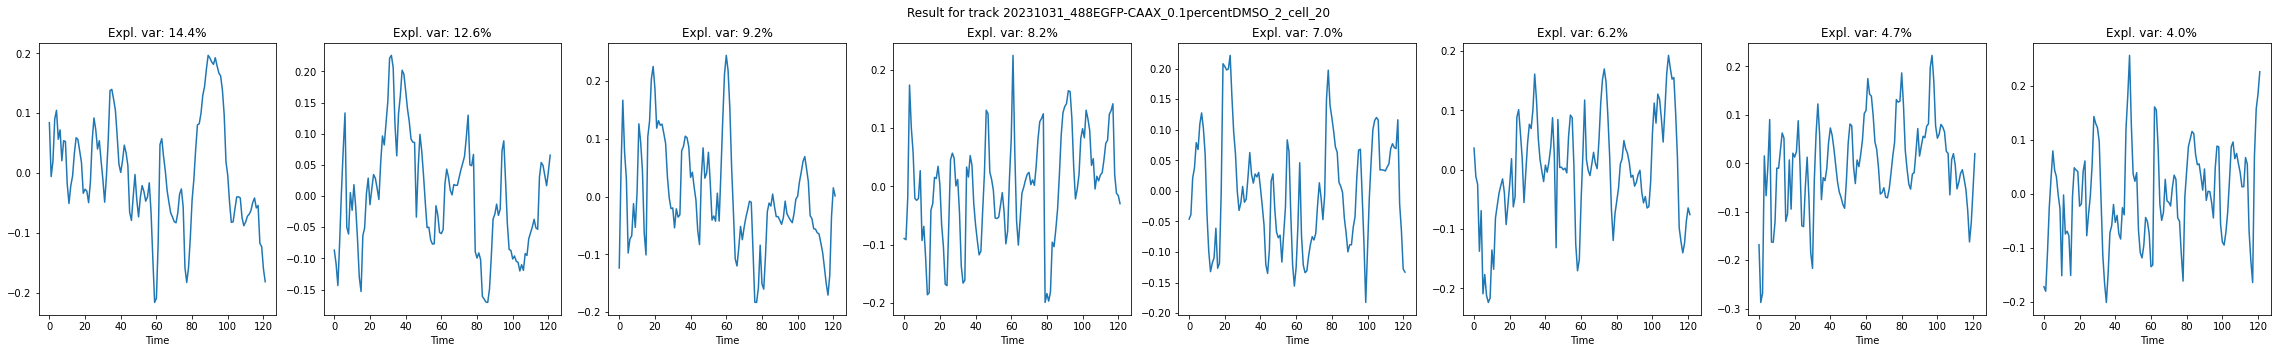

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [33]:
idx=0
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

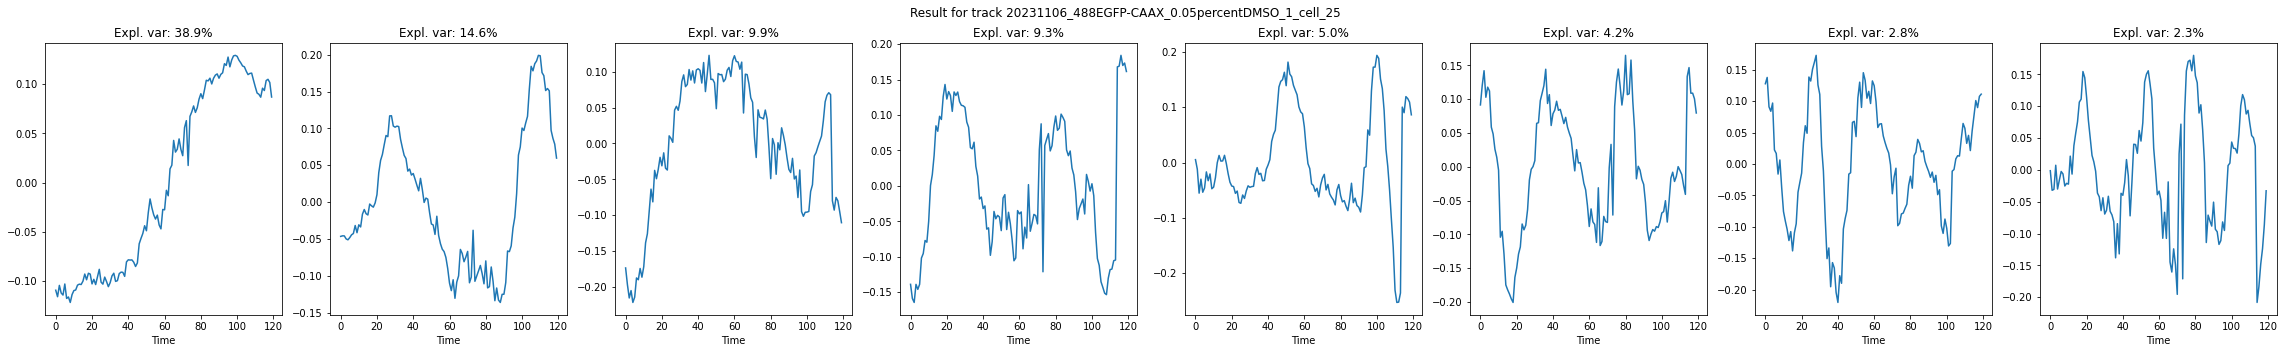

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [34]:
idx=1
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

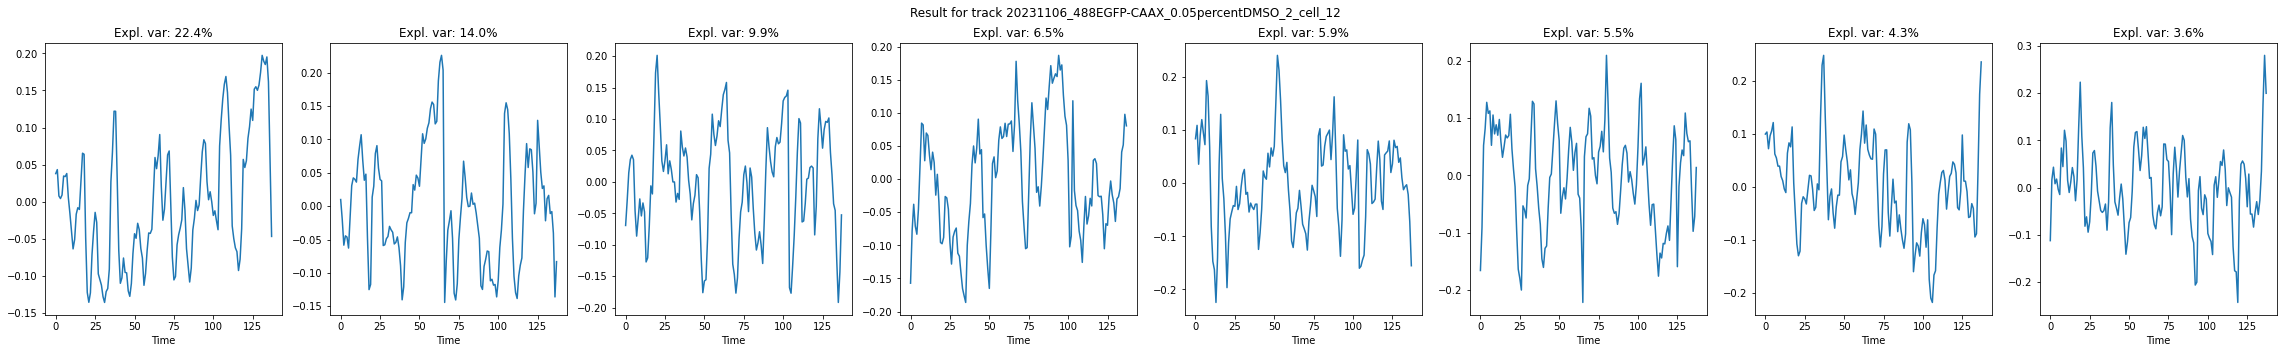

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [35]:
idx=2
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

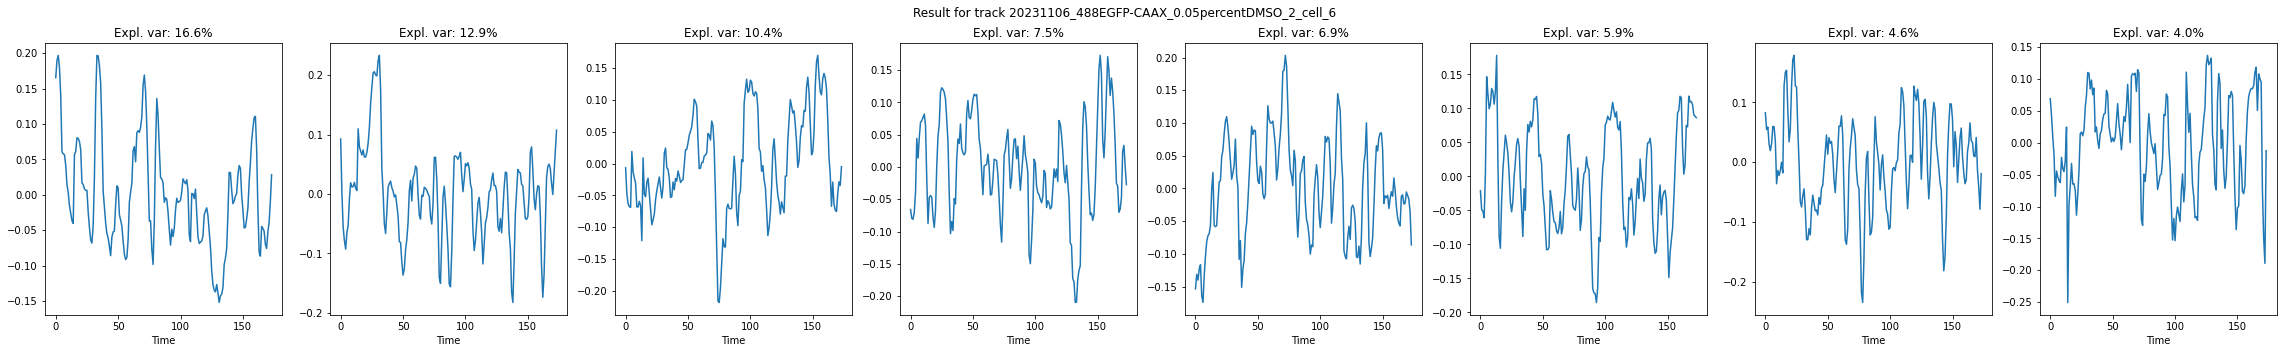

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [36]:
idx=3
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

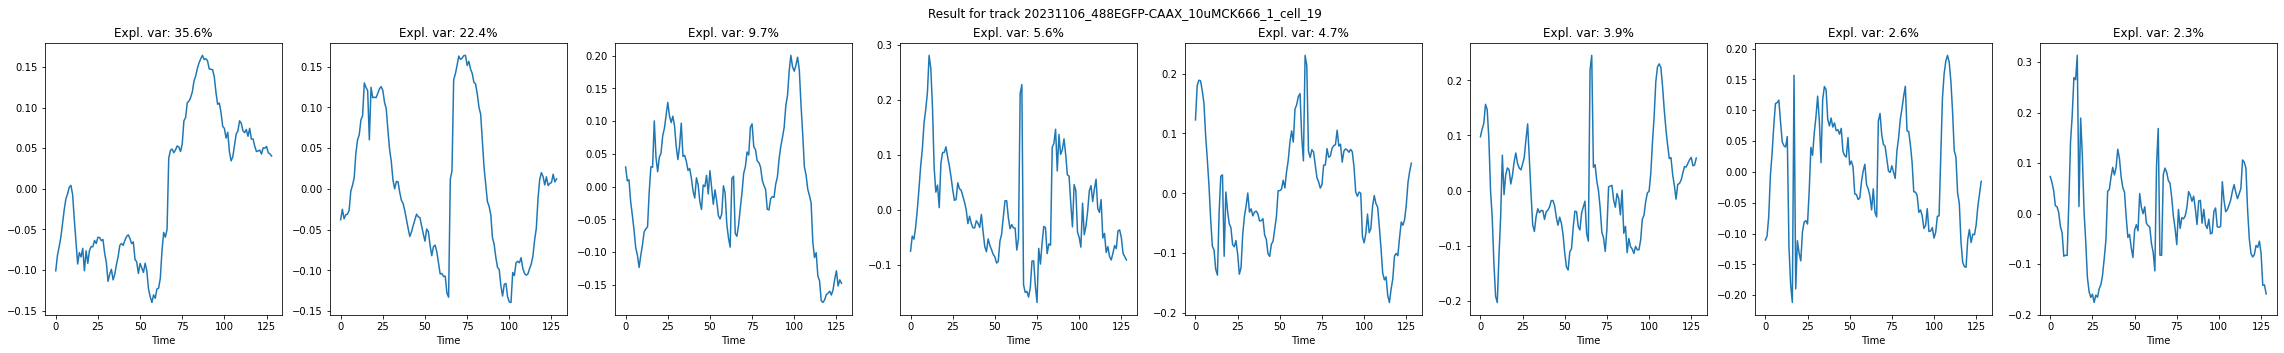

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [37]:
idx=4
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

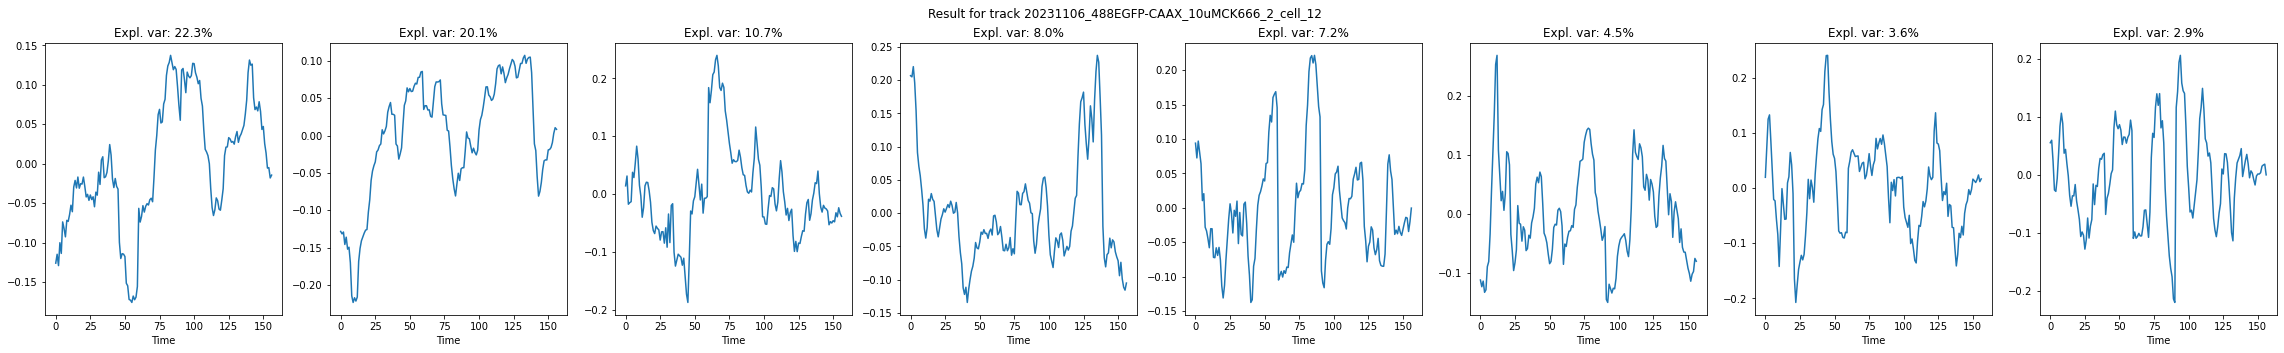

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [39]:
idx=5
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

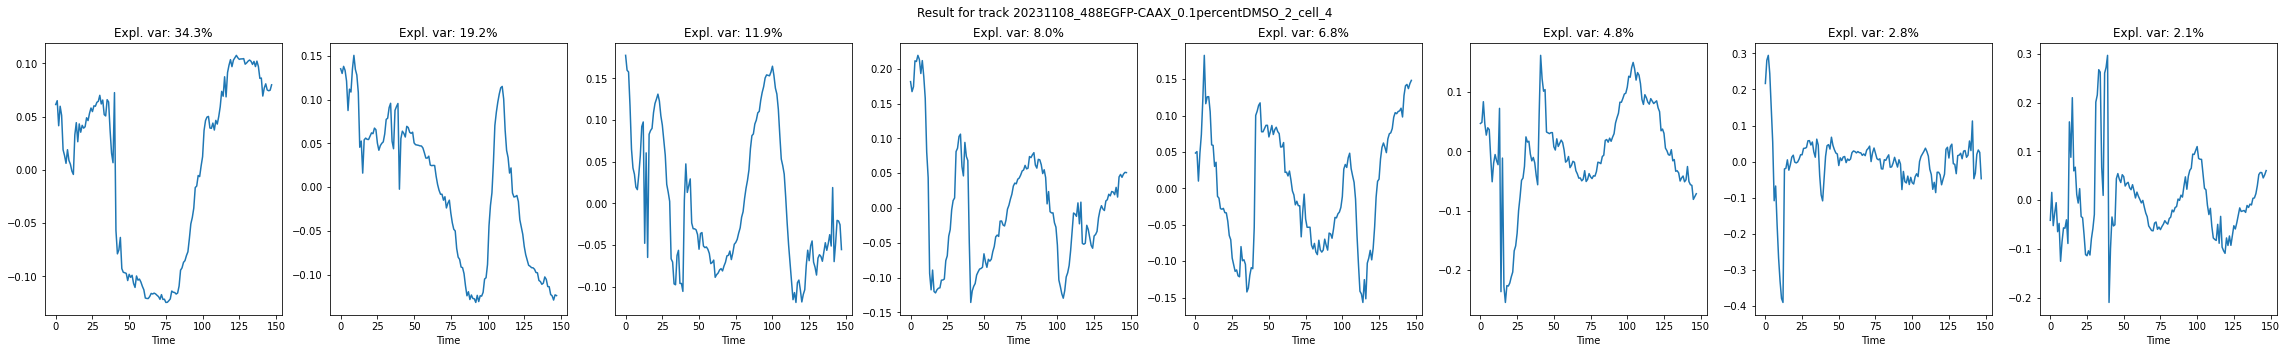

ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [67]:
idx=6
max_modes_viz = 8
fig, ax = plt.subplots(1, max_modes_viz, figsize=(40,5))
for i,dyn in enumerate(list_of_pod_dynamics[idx][:max_modes_viz]):
    ax[i].plot(np.arange(len(dyn)), dyn)
    ax[i].set_xlabel("Time")
    ax[i].set_title(f"Expl. var: {round(list_of_explained_variance[idx][i]*100,1)}%")
plt.suptitle(f"Result for track {list_of_trackids[idx]}")
plt.show()
pl = pv.Plotter(shape=(1,max_modes_viz), window_size=(900,300))
for i,m in enumerate(list_of_mesh_modes_scaled[idx][:max_modes_viz]):
    pl.subplot(0,i)
    pl.add_mesh(m)
pl.show()

In [40]:
list_of_trackids = np.array(list_of_trackids)
n_tracks = len(list_of_trackids)
all_latent_modes = np.array(list_of_pod_modes).reshape(n_tracks*n_modes,-1)
all_scaled_latent_modes = np.array(list_of_pod_modes_scaled).reshape(n_tracks*n_modes,-1)

In [41]:
all_scaled_latent_modes.shape

(320, 242)

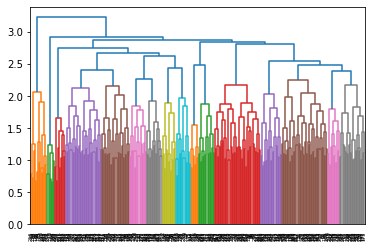

In [42]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(all_latent_modes,"ward")
d = hierarchy.dendrogram(Z)

In [68]:
from scipy.cluster.hierarchy import fcluster
ind = fcluster(Z, 2.8, 'distance')
len(np.unique(ind))

6

In [69]:
grouped_modes_per_cluster_scaled = []
grouped_dynamics_per_cluster = []
for clust_i in np.unique(ind):
    idxs = np.where(ind==clust_i)[0]
    modes_recon_scaled = all_scaled_latent_modes[idxs]
    grouped_modes_per_cluster_scaled.append(modes_recon_scaled)

for gm in grouped_modes_per_cluster_scaled:
    print(len(gm))

16
7
130
23
44
100


In [70]:
avg_clustered_modes = []

for gm in grouped_modes_per_cluster_scaled:
    avg_coeffs = np.average(gm,axis=0)
    lvalues = np.repeat(np.arange(lmax + 1).reshape(-1, 1), lmax + 1, axis=1)
    keys = []
    for suffix in ["C", "S"]:
        for L, m in zip(lvalues.flatten(), lvalues.T.flatten()):
            keys.append(f"shcoeffs_L{L}M{m}{suffix}")

    coeffs_dict = dict(zip(keys, avg_coeffs.flatten()))
    mesh = get_mesh_from_series(coeffs_dict, lmax)
    avg_clustered_modes.append(mesh)

In [84]:
pl = pv.Plotter(shape=(1,len(grouped_modes_per_cluster_scaled)),window_size=(900,300))

for i,am in enumerate(avg_clustered_modes):
    pl.subplot(0,i)
    pl.add_mesh(am)
    pl.add_title(f"Cluster {i+1} \n Clust size={len(grouped_modes_per_cluster_scaled[i])}", font_size=8)

    
pl.show()


ViewInteractiveWidget(height=300, layout=Layout(height='auto', width='100%'), width=900)

In [85]:
from sklearn.metrics import mean_squared_error

list_of_mode_reconstruction_errs_latent_rep = []

for i,full_recon_t in enumerate(list_of_full_reconstructions):
    partial_reconstructions_t = list_of_partial_reconstructions[i]
    mode_recon_err = []
    for pr in partial_reconstructions_t: 
        err = (np.square(pr - full_recon_t).mean(axis=1))#np.subtract(np.abs(pr),np.abs(full_recon_t))
        mode_recon_err.append(err)
    list_of_mode_reconstruction_errs_latent_rep.append(mode_recon_err)

In [86]:
df["CellID"].value_counts().max()

174

In [87]:
cluster_activation_maps = []
for i,t_mode_errs in enumerate(list_of_mode_reconstruction_errs_latent_rep):
    t_mode_errs = np.array(t_mode_errs)
    scaled_errs = (t_mode_errs.T / list_of_singular_values[i]).T
    max_mode_mapping = []
    for t in range(t_mode_errs.shape[1]):
        max_mode_idx = np.nanargmax(scaled_errs[:,t])
        max_mode_mapping.append(max_mode_idx)
    flat_idx_max_mode_mapping = i*n_modes+np.array(max_mode_mapping)
    matching_clust_ids = ind[flat_idx_max_mode_mapping]
    cluster_activation_maps.append(matching_clust_ids)

max_len = df["CellID"].value_counts().max()
pad_cluster_activation_maps = []
for cam in cluster_activation_maps:
    if cam.shape[0] != max_len:
        rem = max_len - cam.shape[0]
        padded_cam = np.pad(cam.astype(float),(0,rem),mode='constant',constant_values=(np.nan,))
        pad_cluster_activation_maps.append(padded_cam)
    else:
        pad_cluster_activation_maps.append(cam)

cluster_activation_maps = np.array(pad_cluster_activation_maps)
cluster_activation_maps.shape

(10, 174)

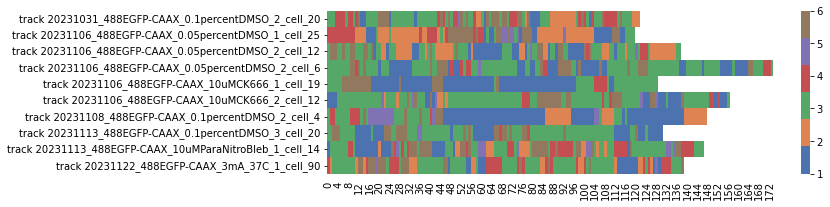

In [88]:
import seaborn as sns
inds = []
for i,t in enumerate(list_of_trackids):
    inds.append(i)
act_maps = cluster_activation_maps[inds]
inds_track_labels = [f"track {t}" for t in list_of_trackids[inds]]

f, ax = plt.subplots(figsize=(10,3))
ax.tick_params(bottom = False)
sns.heatmap(act_maps, 
            cmap=sns.color_palette("deep", 
                                   len(np.unique(ind))),
                                   ax=ax, 
                                   yticklabels=inds_track_labels)
plt.show()